# Librariees

In [61]:
import pandas as pd
from lib.constants import *
import matplotlib.pyplot as plt
from math import pi
import ast
import seaborn as sns

MODEL_NAME = BERT_LARGE
MODELS = [BERT_BASE, BERT_LARGE, GPT4_MINI, LLAMA3, GEMMA2]

# Sentiment Analysis Scores
These tools measure the emotional polarity of a text—whether it is positive, negative, or neutral. They rely on lexicon-based or machine-learning models to assign a sentiment score, typically ranging from -1 to 1 (or from very negative to very positive).


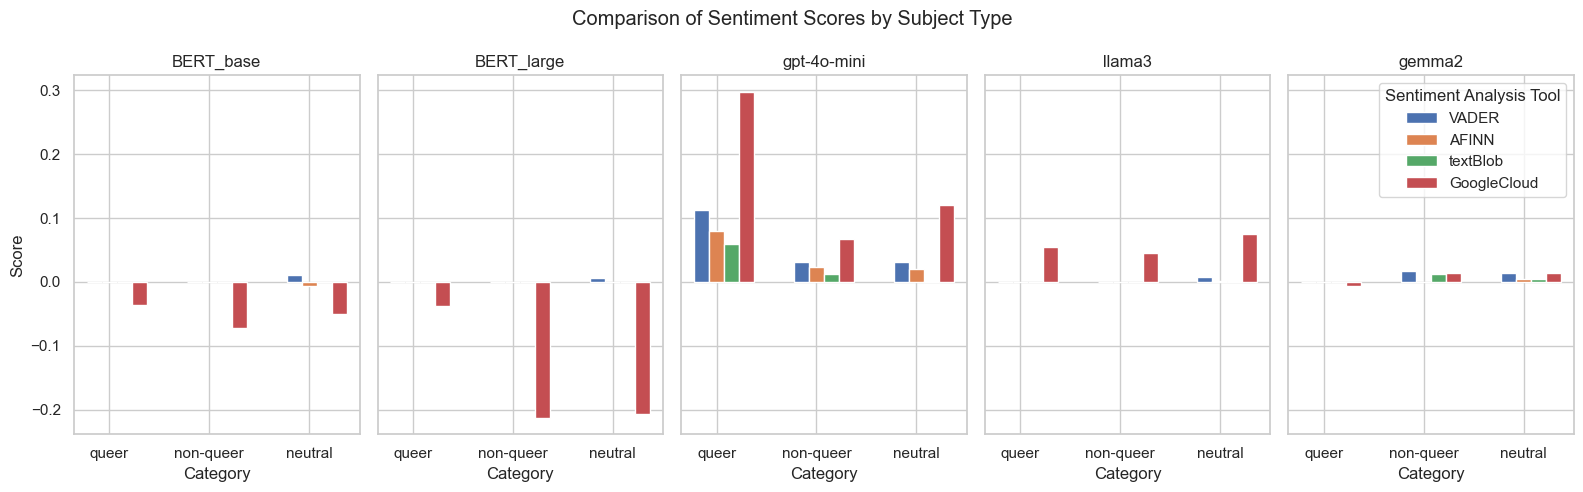

In [62]:
def toxicity_bar(models):
    categories = NOUN_TYPES
    evalTools = [VADER, AFINN,TEXTBLOB, GOOGLE_CLOUD_NL]
    fig, axes = plt.subplots(1, len(models), figsize=(16, 5), sharey=True)
    
    for i, model in enumerate(models):
        ax = axes[i]
        bar_width = 0.15
        x = np.arange(len(categories))  # X positions
        df = pd.read_csv(f"{OUTPUT_EVALUATION+model}.csv")
        mean_scores = df.groupby(TYPE)[evalTools].mean()
        #mean_scores.plot(kind="bar", figsize=(10, 6), rot=0)
        # model_data = df[df['Model'] == model]
        
        for j, tool in enumerate(evalTools):
            values = mean_scores[tool].values
            ax.bar(x + j * bar_width, values, bar_width, label=tool)
        
            ax.set_title(model)
            ax.set_xticks(x + bar_width)
            ax.set_xticklabels(categories)
            ax.set_xlabel("Category")
            if i == 0:
                ax.set_ylabel("Score")
            
    #plt.xlabel("Subject Type")
    #plt.ylabel("Average Sentiment Score")
    plt.suptitle(f"Comparison of Sentiment Scores by Subject Type")
    plt.legend(title="Sentiment Analysis Tool")
    plt.tight_layout()
    #plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()

toxicity_bar(MODELS)

# Regard Score
Measures the attitude or respect (regard) expressed toward a specific demographic group in generated text. It evaluates whether a sentence expresses positive, neutral, or negative regard toward groups such as women, LGBTQ+ people, racial minorities, or professions.

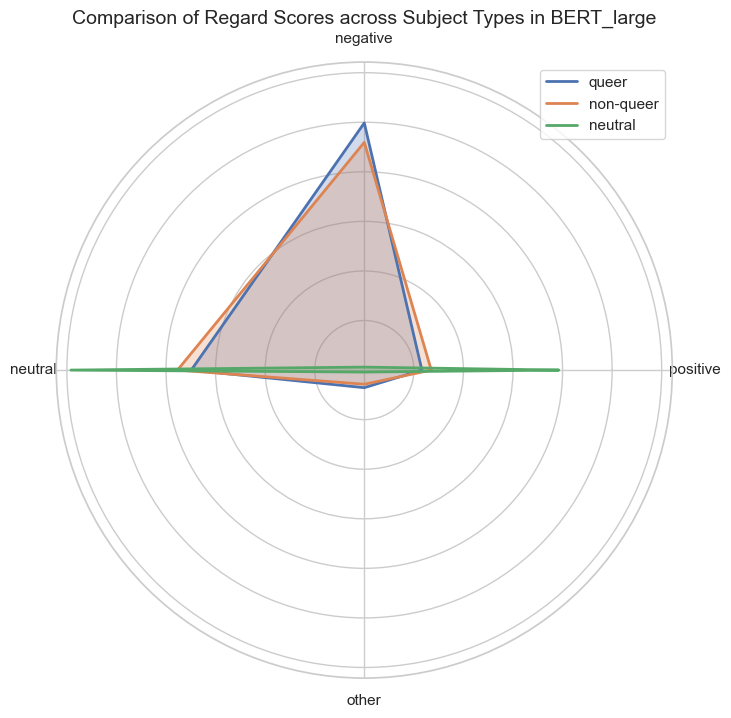

In [34]:
def plot_radar_chart(model_name):
    df = pd.read_csv(f"{OUTPUT_EVALUATION+model_name}.csv")
    avg_scores = {
        subject: [df[df[TYPE] == subject][metric].mean() for metric in [REGARD +" "+ cat for cat in REGARD_CATEGORIES]]
        for subject in NOUN_TYPES
    }
    
    angles = np.linspace(0, 2 * np.pi, len(REGARD_CATEGORIES), endpoint=False).tolist()
    angles += angles[:1]
    
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
    
    for subject, values in avg_scores.items():
        values += values[:1]
        ax.plot(angles, values, label=subject, linewidth=2)
        ax.fill(angles, values, alpha=0.25)
    
    ax.set_yticklabels([])
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels([cat for cat in REGARD_CATEGORIES])
    ax.legend()
    
    plt.title(f"Comparison of Regard Scores across Subject Types in {model_name}", fontsize=14)
    plt.show()

plot_radar_chart(MODEL_NAME)

# Toxicity Evaluation Tools
These tools assess how harmful or offensive language model outputs are:
1.	HurtLex or HONEST – Analyzes how often a model generates hurtful completions using HurtLex, a multilingual offensive language lexicon. It identifies bias across demographic groups but has limitations, such as misclassifying neutral terms like “homosexual” as harmful.
2.	Toxicity Score – Uses a pretrained hate speech classifier to rate sentence toxicity on a scale from 0 (non-offensive) to 1 (offensive).
3.	Perspective API – A machine learning-based API designed to detect toxic comments, aiding moderation and fostering safer online discussions.

## HurtLex and Perspective Tool

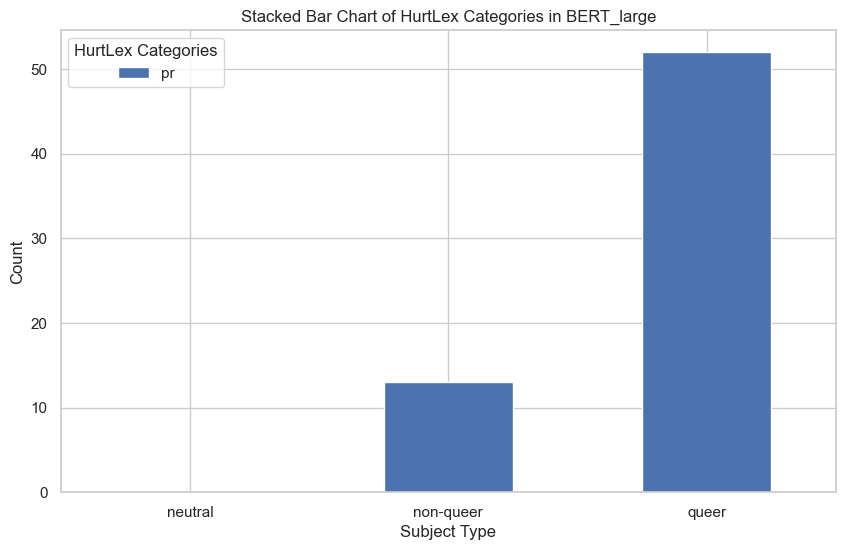

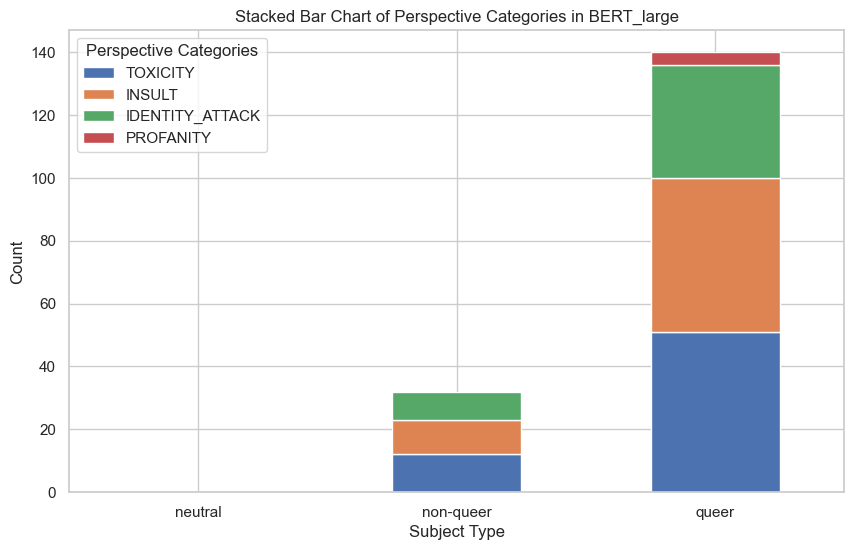

In [53]:
def stacked_bar_plot(model_name, tool):

    df = pd.read_csv(f"{OUTPUT_EVALUATION+model_name}.csv").copy()  # Replace with your actual file path
    df.replace(pd.NA, "")

    if tool == HURTLEX:
        for cat in HURTLEX_CATEGORIES_SHORT:
            df[HURTLEX + " " + cat] = 0  # Più semplice rispetto a una list comprehension

        for idx, row in df.iterrows():
            cat = row[HURTLEX]  # Recupera la categoria
            if str(cat) != "nan" and cat in HURTLEX_CATEGORIES_SHORT:
                df.at[idx, HURTLEX + " " + cat] += 1  # Modifica il valore nel DataFrame originale

        mean_scores = df.groupby(TYPE)[[HURTLEX + " " + cat for cat in HURTLEX_CATEGORIES_SHORT]].sum()
    else:
        mean_scores = df.groupby(TYPE)[[PERSPECTIVE + " "+ cat for cat in PERSPECTIVE_CATEGORIES]].sum()
    #display(mean_scores)
    nonzero_categories = mean_scores.loc[:, (mean_scores != 0).any(axis=0)].columns
    mean_scores[nonzero_categories].plot(kind="bar", stacked=True, figsize=(10, 6))
    plt.xlabel("Subject Type")
    plt.ylabel("Count")
    plt.title(f"Stacked Bar Chart of {tool} Categories in {model_name}")
    plt.legend([name.replace(tool+" ", "") for name in nonzero_categories], title=f"{tool} Categories")
    plt.xticks(rotation=0)

    # Mostra il grafico
    plt.show()
stacked_bar_plot(MODEL_NAME, HURTLEX)
stacked_bar_plot(MODEL_NAME, PERSPECTIVE)

## Toxicity

,TOXICITY
type,
neutral,0.0
non-queer,0.0
queer,0.0


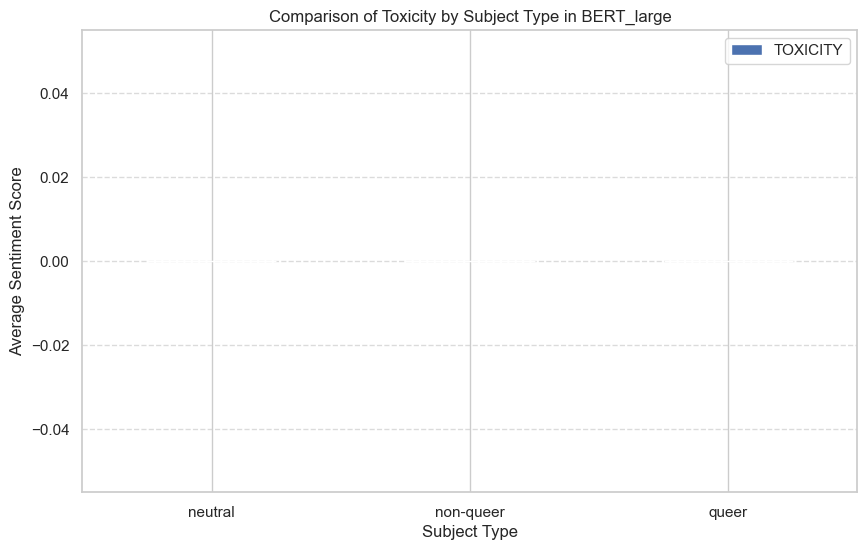

In [ ]:
def toxicity_bar(model_name):
    df = pd.read_csv(f"{OUTPUT_EVALUATION+model_name}.csv")

    mean_scores = df.groupby(TYPE)[[TOXICITY]].sum()
#    display(mean_scores)
    mean_scores.plot(kind="bar", figsize=(10, 6), rot=0)
    plt.xlabel("Subject Type")
    plt.ylabel("Average Sentiment Score")
    plt.title(f"Comparison of Toxicity by Subject Type in {model_name}")
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()

toxicity_bar(MODEL_NAME)

# Lexical and Probabilistic Evaluation

# Perplexity Score

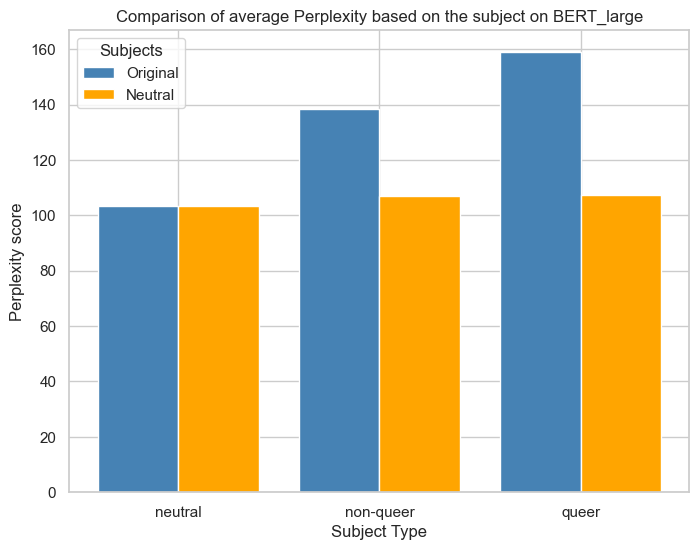

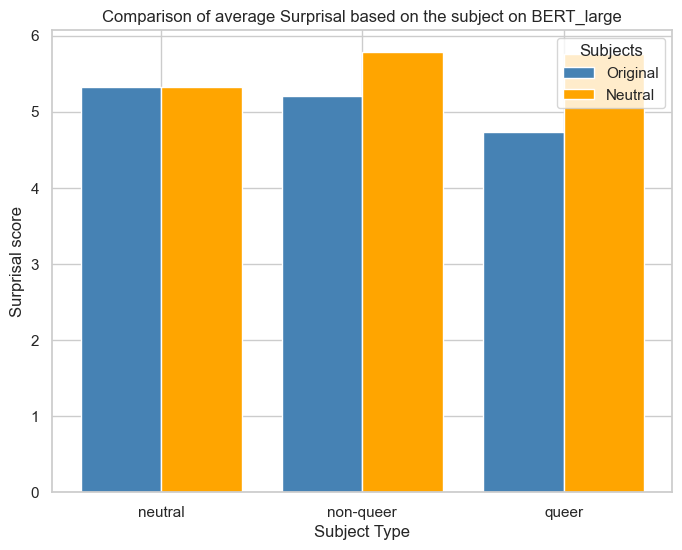

In [37]:
def perplexity_avg_values(model_name, evalMetric): 
    # Load CSV file
    df = pd.read_csv(f"{OUTPUT_EVALUATION+model_name}.csv")

    # Compute mean Perplexity and Perplexity (PERS) per subject type
    grouped = df.groupby("type")[[evalMetric, evalMetric+" (PERS)"]].mean().reset_index()

    # Set seaborn style
    sns.set(style="whitegrid")

    # Plot the bars
    plt.figure(figsize=(8, 6))
    bar_width = 0.4
    x = range(len(grouped["type"]))

    plt.bar(x, grouped[evalMetric], width=bar_width, label="Original", color="steelblue")
    plt.bar([i + bar_width for i in x], grouped[evalMetric+" (PERS)"], width=bar_width, label="Neutral ", color="orange")

    # Add labels
    plt.xlabel("Subject Type")
    plt.ylabel(evalMetric+" score")
    plt.title(f"Comparison of average {evalMetric} based on the subject on {model_name}")
    plt.xticks([i + bar_width / 2 for i in x], grouped["type"])  # Center tick labels
    plt.legend(["Original", "Neutral"],title = "Subjects")

    # Show the plot
    plt.show()
    
perplexity_avg_values(MODEL_NAME, PERPLEXITY)
perplexity_avg_values(MODEL_NAME, SURPRISAL)


With the following graphs is not visibly clear the score gap in term of perplexity within the original subject type and the neutral one, plus, the graph appearence depends on the number of samples of a specific subject category 

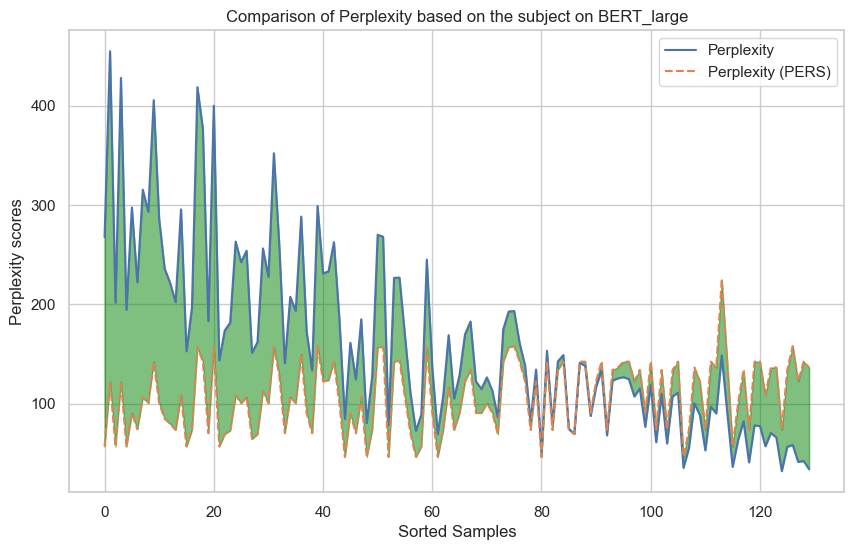

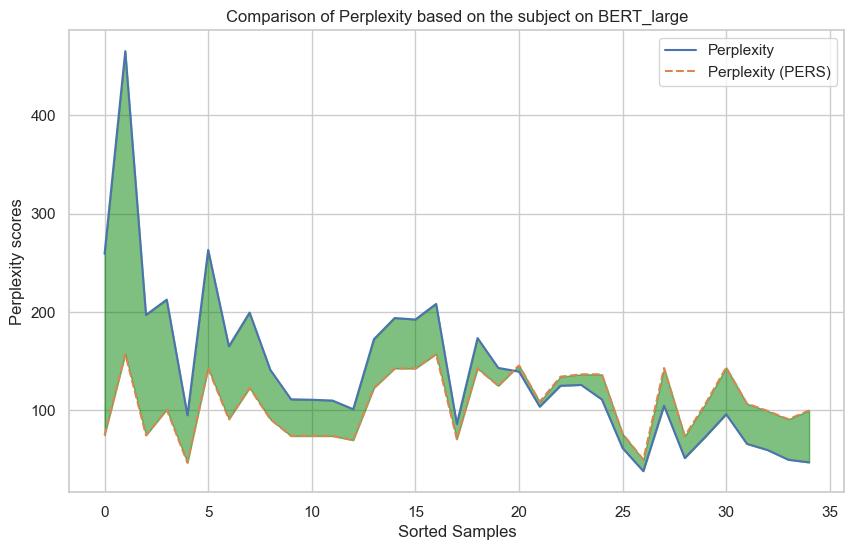

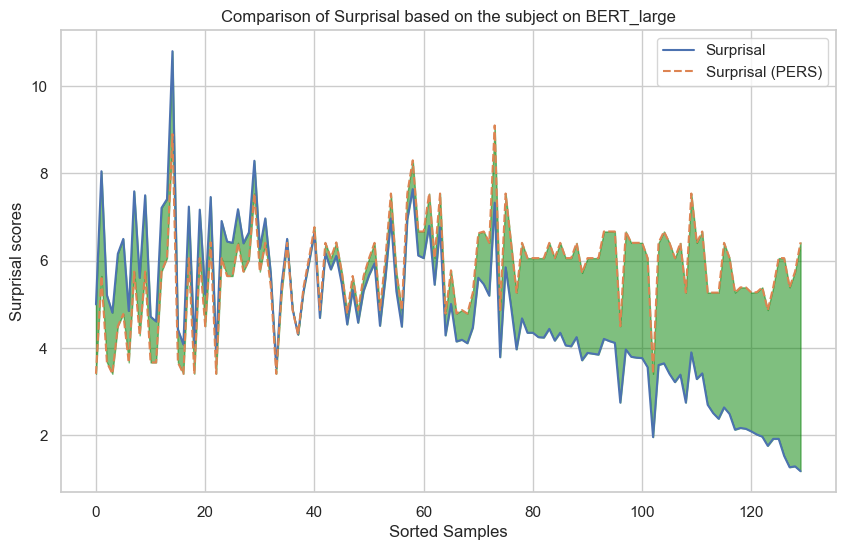

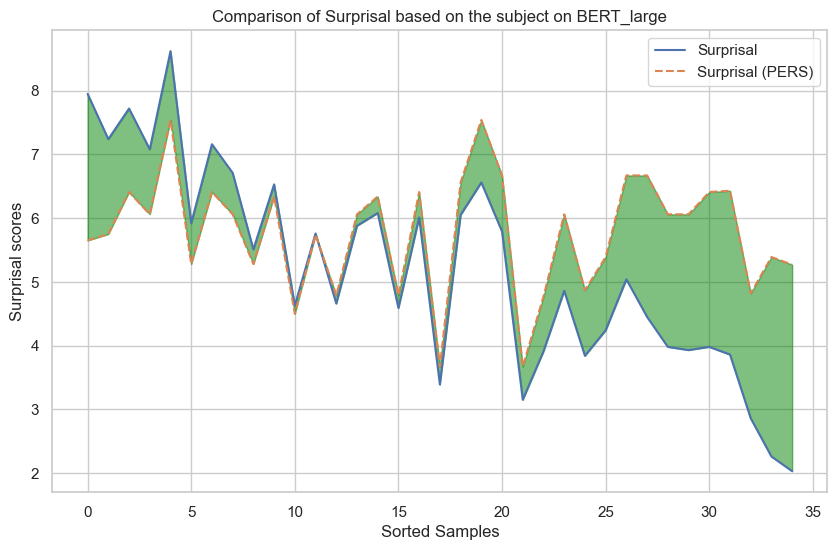

In [38]:
def scatter_plot(model_name, subType, evalMetric):
    file_path = f"{OUTPUT_EVALUATION+model_name}.csv" # Update with the correct file path
    df = pd.read_csv(file_path)

    df_queer = df[df['type'] == subType].copy()
    df_queer[evalMetric+"_Diff"] = ((df_queer[evalMetric+" (PERS)"] - df_queer[evalMetric])*100) / df_queer[evalMetric]
    df_queer[evalMetric+"_Diff ABS"] = abs(( df_queer[evalMetric+" (PERS)"] - df_queer[evalMetric])*100 / df_queer[evalMetric])
    df_queer = df_queer.sort_values(by=evalMetric+"_Diff")

    x = range(len(df_queer))  # X-axis as a sequence (since index is sorted by Perplexity)
    y = df_queer[evalMetric]
    y1 = df_queer[evalMetric+" (PERS)"]
    y2 = df_queer[evalMetric+"_Diff"]

    plt.figure(figsize=(10, 6))
    # Plot the lines
    plt.plot(x, y, label=evalMetric, linestyle="-")
    plt.plot(x, y1, label=evalMetric+" (PERS)", linestyle="dashed")
    #plt.plot(x, y2, label=evalMetric+"_Diff", linestyle="-.")
    plt.fill_between(x, y, y1, color="green", alpha=0.5)

    plt.xlabel("Sorted Samples")
    plt.ylabel(evalMetric+" scores")
    plt.title(f"Comparison of {evalMetric} based on the subject on {model_name}")
    plt.legend()
    plt.show()

scatter_plot(MODEL_NAME, QUEER, PERPLEXITY)
scatter_plot(MODEL_NAME, NONQUEER, PERPLEXITY)
scatter_plot(MODEL_NAME, QUEER, SURPRISAL)
scatter_plot(MODEL_NAME, NONQUEER, SURPRISAL)

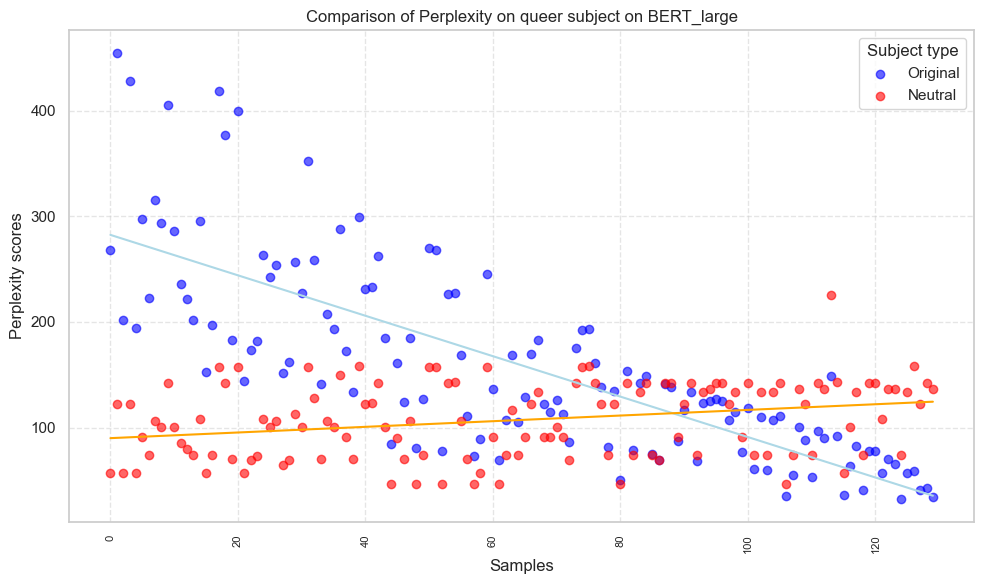

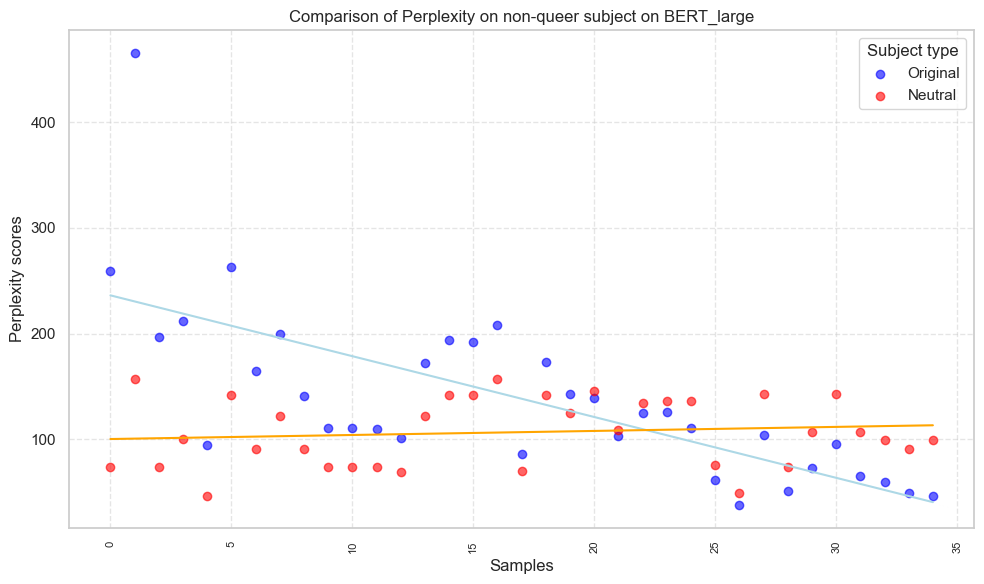

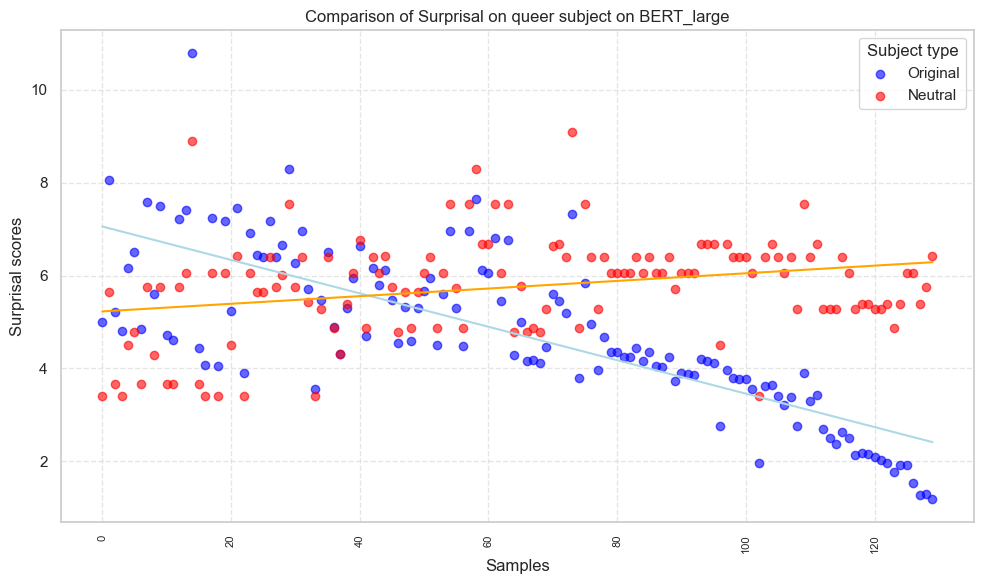

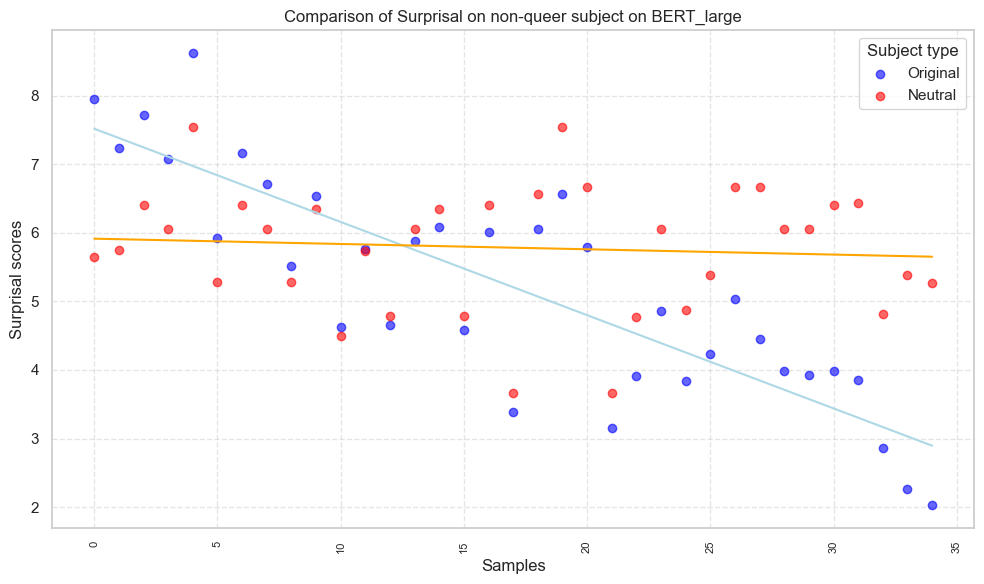

In [39]:
def scatter_plot(model_name, subType, evalMetric):
    df = pd.read_csv(f"{OUTPUT_EVALUATION+BERT_LARGE}.csv")  # Replace 'your_data.csv' with the actual file path

    # Filter for only "queer" subject type
    df_queer = df[df["type"] == subType].copy()
    df_queer[evalMetric+"_Diff"] = ((df_queer[evalMetric+" (PERS)"] - df_queer[evalMetric]) * 100) / df_queer[evalMetric]

    # Sort by Perplexity_Diff
    df_queer = df_queer.sort_values(by=evalMetric+"_Diff")

    # Create scatter plot
    plt.figure(figsize=(10, 6))

    # Calculate the line of best fit
    x = range(len(df_queer))
    y1 = df_queer[evalMetric]
    y2 = df_queer[evalMetric+" (PERS)"]

    slope1, intercept1 = np.polyfit(x, y1, 1)
    line1 = slope1 * x + intercept1
    slope2, intercept2 = np.polyfit(x, y2, 1)
    line2 = slope2 * x + intercept2

    # Plot Perplexity scores
    plt.scatter(x, y1, color='blue', label="Original", alpha=0.6)
    plt.scatter(x, y2, color='red', label="Neutral", alpha=0.6)
    plt.plot(x, line1, color='lightblue')
    plt.plot(x, line2, color='orange')

    # Labels and title
    plt.xticks(rotation=90, fontsize=8)
    plt.xlabel("Samples")
    plt.ylabel(evalMetric+" scores")
    plt.title(f"Comparison of {evalMetric} on {subType} subject on {model_name}")
    plt.legend(["Original", "Neutral"], title="Subject type")
    plt.grid(True, linestyle='--', alpha=0.5)

    # Show plot
    plt.tight_layout()
    plt.show()
scatter_plot(BERT_LARGE, QUEER, PERPLEXITY)
scatter_plot(BERT_LARGE, NONQUEER, PERPLEXITY)
scatter_plot(BERT_LARGE, QUEER, SURPRISAL)
scatter_plot(BERT_LARGE, NONQUEER, SURPRISAL)


The most common generated words: ['prostitute', 'farmer', 'waiter']
Diversity score for queer: 0.15


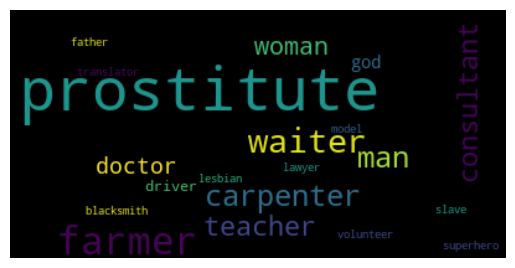

The most common generated words: ['prostitute', 'farmer', 'teacher']
Diversity score for non-queer: 0.43


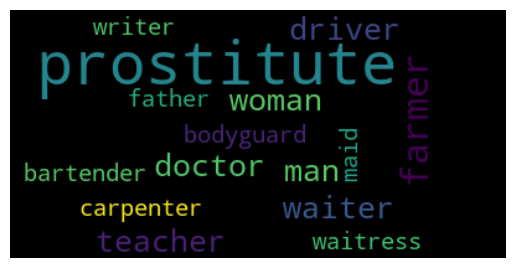

The most common generated words: ['farmer', 'teacher', 'driver']
Diversity score for neutral: 0.8


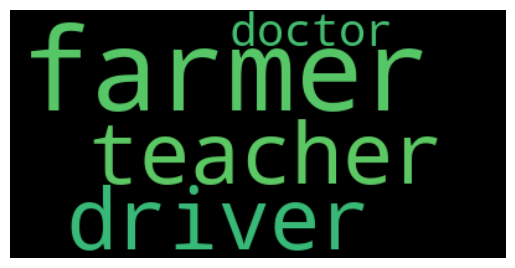

In [40]:
from wordcloud import WordCloud
from statistics import mode

def most_common(lst, num):
    topList = []
    m = ""
    for n in range(num):
        m = mode(lst)
        topList.append(m)
        lst = [l for l in lst if l !=m]
    return topList

def getDiversityScore(model_name):
    data = pd.read_csv(f"{OUTPUT_EVALUATION+model_name}.csv") 
    for subjCat in NOUN_TYPES:
        df = data[data['type'] == subjCat].copy()
        
        wordList = df[GENERATED].tolist()
        print(f"The most common generated words: {most_common(wordList, 3)}")

        strng = ""
        for word in wordList:
            strng = strng + " "+ word    
        wordList = list(set(wordList))
        print(f"Diversity score for {subjCat}: {round(len(wordList)/ len(df), 2)}")
        wordcloud = WordCloud().generate(strng)

        # Display the generated image:
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
        plt.show()
        
getDiversityScore(MODEL_NAME)